# LTSM Model fabric

In [2]:
import tensorflow as tf 
from tensorflow.keras.preprocessing import sequence

In [3]:
def createModelLSTM(target_vocab_size, target_layer_neuron_count, target_review_length
                    , dropout_rate = 0.2, out_units = 1):
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units = target_layer_neuron_count # 32 LSTM units in this layer
        ))

    # Начнем с определения пустого стека. Мы будем использовать его для создания 
    # сети, позже по слоям.
    model = tf.keras.models.Sequential()

    # The Embedding Layer Word2Vec
    model.add(
        tf.keras.layers.Embedding(
            input_dim = target_vocab_size,                 # The size of our vocabulary 
            output_dim = target_layer_neuron_count,        # Dimensions to which each words shall be mapped
            input_length = target_review_length            # Length of input sequences
        )
    )

    # Dropout 
    model.add(
        tf.keras.layers.Dropout(
            rate=dropout_rate                                # Randomly disable 25% of neurons
        )
    )

    model.add(
        tf.keras.layers.LSTM(
            units = target_layer_neuron_count              # 32 LSTM units in this layer
        )
    )

    # Add a second dropout layer with the same aim as the first.
    model.add(
        tf.keras.layers.Dropout(
            rate=dropout_rate                                # Randomly disable 25% of neurons
        )
    )

    # Все блоки LSTM подключены к одному узлу в Dense слое.
    # Функция активации сигмоида определяет выходной сигнал от этого узла - значение от 0 до 1. 
    #Ближе к 0 указывает на отрицательный обзор. Ближе к 1 означает положительный отзыв.
    model.add(
        tf.keras.layers.Dense(
            units=out_units,                                # Single unit
            activation='sigmoid'                    # Sigmoid activation function (output from 0 to 1)
        )
    )

    # Compile the model
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,   # loss function
        optimizer=tf.keras.optimizers.Adam(),       # optimiser function
        metrics=['accuracy']                       # reporting metric
    )
    return model

# Задание 1

Попробуйте улучшить результаты нейронной сети LSTM  из практического занятия поэкспериментировав с параметрами нейронной сети:
* Размер словаря,
* длина отзыва,
* размер слоя эмбеддинг

## Import

In [1]:
import numpy as np
from numpy import array
from numpy import iterable

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

2022-10-20 12:28:22.119639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 12:28:22.451264: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 12:28:22.584933: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 12:28:23.892582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [32]:
# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# setting seed
def resetSeed():
    seed = 3
    np.random.RandomState(seed)
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
resetSeed()

## Параметры

In [3]:
vocab_size = 10000 # the 10000 most commonly used words
review_length = 250 # The length of reviews
layer_neuron_count = 32 # Размер слоя

## Создать карту для преобразования набора данных IMDB в удобочитаемые обзоры

Обзоры в наборе данных IMDB были закодированы как последовательность целых чисел. К счастью, набор данных также
содержит указатель для преобразования отзывов в удобочитаемую форму.

In [4]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms
# Сдвигаем все итемы на 3 и добавляем слова-заглушки
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

In [5]:
# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [6]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

def encode_review(text, targetLen):
    aText = []
    if iterable(text):
        aText = text
    else:
        aText.append(text)
    
    aResult = []
    for t in aText:
        tmp = []
        for word in t.split(" "):
            tmp.append(word_index[word])
        aResult.append(tmp)

    return sequence.pad_sequences(aResult, maxlen=targetLen, padding='post') 

In [ ]:
word_index

In [ ]:
reverse_word_index

## Load Dataset

In [3]:
# Fetch "IMDB Movie Review" data, constraining our reviews to 
def loadDataIMDB(target_vocab_size, verbose_level = 0):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
    if verbose_level > 0:
        print(f"LenArray: {len(X_train)}\nLen: {len(X_train[0])}\n{X_train[0]}")
    return (X_train, y_train), (X_test, y_test)

In [4]:
# Map for readable classnames
class_names = ["Negative", "Positive"]

In [9]:
(X_train, y_train), (X_test, y_test) = loadDataIMDB(vocab_size)

### Пример ревью



In [14]:
# Concatonate test and training datasets
allreviews = np.concatenate((X_train, X_test), axis=0)

#### Длина ревью

In [15]:
# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892


#### Ревью в машинном виде

In [16]:
# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("  Review Text: " + str(X_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

  Review Text: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: Negative


#### Ревью в словестном виде

In [17]:
# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("  Review Text: " + decode_review(X_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

  Review Text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> but you could tell they're the types that get off on violence i bet anything they frequent <UNKNOWN> and do drugs br br don't waste your time i had to keep my boyfriend from walking out of it
  Review Sentiment: Negative


## Нормализация данных

Нам нужно убедиться, что наши обзоры имеют одинаковую длину. Это для параметров LSTM.

Некоторые отзывы нужно будет усечь, а другие дополнить.

In [5]:
def normalizeDataSet(target_length, X_train, X_test, verbose_level = 0):
    # Padding / truncated our reviews
    X_train_normalized = sequence.pad_sequences(X_train, maxlen = target_length, padding='post')
    X_test_normalized = sequence.pad_sequences(X_test, maxlen = target_length, padding='post')

    # Check the size of our datasets. Review data for both test and training should 
    # contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
    # one for each review. Class values are 0 or 1, indicating a negative 
    # or positive review.
    if verbose_level > 0:
        print(f"Shape Training Review Data: {X_train_normalized.shape}")
        print(f"Shape Training Class Data: {y_train.shape}")
        print(f"Shape Test Review Data: {X_test_normalized.shape}")
        print(f"Shape Test Class Data: {y_test.shape}")
    return [X_train_normalized, X_test_normalized]

In [11]:
X_train_normalized, X_test_normalized = normalizeDataSet(review_length, X_train, X_test)

### Ревью в словестном виде после нормализации

In [20]:
# Note padding is added to start of review, not the end
print("Human Readable Review Text (post padding): " + decode_review(X_train_normalized[60]))

Human Readable Review Text (post padding): <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> but you could tell they're the types that get off on violence i bet anything they frequent <UNKNOWN> and do drugs br br don't waste your time i had to keep my boyfriend from walking out of it <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

## Create and build LSTM Recurrent Neural Network

In [36]:
model = createModelLSTM(vocab_size, layer_neuron_count, review_length)

# Display a summary of the models structure
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 175, 256)          768000    
                                                                 
 dropout_72 (Dropout)        (None, 175, 256)          0         
                                                                 
 lstm_73 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_73 (Dropout)        (None, 256)               0         
                                                                 
 dense_36 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,293,569
Trainable params: 1,293,569
Non-trainable params: 0
_________________________________________________________________


### Visualise the Model

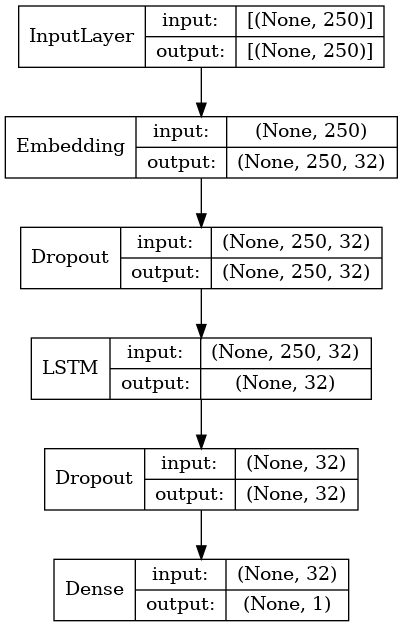

In [14]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Обучение

In [34]:
def fitModelLSTM(model, X_train, y_train, verbose_level = 0):
    return model.fit(
        X_train, y_train,                   
        batch_size = 128, 
        epochs = 1,
        validation_split = 0.2,    
        verbose = verbose_level)

def predictModelLSTM(model, X):
    return np.argmax(model.predict(X), axis = 1)

In [37]:
# Train the LSTM on the training data
history_original = fitModelLSTM(model, X_train_normalized, y_train)

### Evaluate model with test data and view results

In [39]:
score_original = model.evaluate(X_test_normalized, y_test)

782/782 [==============================] - 7s 9ms/step - loss: 0.7265 - accuracy: 0.5147


In [40]:
# Get Model Predictions for test data
predicted_classes = predictModelLSTM(model, X_test_normalized)
print(report_original := classification_report(y_test, predicted_classes, target_names=class_names))

782/782 [==============================] - 6s 8ms/step
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67     12500
    Positive       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Выведем несколько примеров некорретных отзывов


In [ ]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped != y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(X_test_normalized[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

### Проверим модель на наших собственных данных



In [23]:
# Write your own review

review1 = "<START> this was a terrible film with too much sex and violence"
review2 = "<START> this is the best film i have ever seen it is great and fantastic and i loved it"
review3 = "<START> i dont think this movie is bad or good"
aReview = [review1, review2, review3]

# Encode review (replace word with integers)
tmp_padded = encode_review(aReview, review_length)

# Run your processed review against the trained model
rawprediction = model.predict(array([tmp_padded][0]))

# Test the model and print the result
for i, review in enumerate(aReview):
    print("Review: " + review)
    print("Raw Prediction: " + str(rawprediction[i]))
    prediction = int(np.round(rawprediction[i]))
    print("Predicted Class: " + class_names[prediction])
    print("")

1/1 [==============================] - 0s 26ms/step
Review: <START> this was a terrible film with too much sex and violence
Raw Prediction: [0.31093034]
Predicted Class: Negative

Review: <START> this is the best film i have ever seen it is great and fantastic and i loved it
Raw Prediction: [0.82551855]
Predicted Class: Positive

Review: <START> i dont think this movie is bad or good
Raw Prediction: [0.31092954]
Predicted Class: Negative



## Util Plot

In [8]:
def plotAccLossDiagramMean(models_score, models_history, x_ticks_range):
    
    val_loss = np.mean(np.array(models_score)[:, :,0].T, axis=1)
    val_acc = np.mean(np.array(models_score)[:, :,1].T, axis=1)
    
    acc, loss = [], []
    for iBatch in range(len(models_score)):
        acc.append([h.history['accuracy'][-1] for h in models_history[iBatch]])
        loss.append([h.history['loss'][-1] for h in models_history[iBatch]])
    acc = np.mean(acc, axis=0)
    loss = np.mean(loss, axis=0)

    plotAccLossDiagramImp(acc, loss, val_acc, val_loss, x_ticks_range)

def plotAccLossDiagram(models_score, models_history, x_ticks_range):
    nBatch = len(models_score)

    for iBatch in range(nBatch):

        val_acc = np.array(models_score[iBatch])[:,1]
        val_loss = np.array(models_score[iBatch])[:,0]
        acc = [h.history['accuracy'][-1] for h in models_history[iBatch]]
        loss = [h.history['loss'][-1] for h in models_history[iBatch]]

        plotAccLossDiagramImp(acc, loss, val_acc, val_loss, x_ticks_range)

def plotAccLossDiagramImp(acc, loss, val_acc, val_loss, x_ticks_range):
    plt.figure(figsize=(15,5))
    x_ticks_range_index = range(len(x_ticks_range))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(x_ticks_range_index, acc, 'bo', label='Training accuracy')
    plt.plot(x_ticks_range_index, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xticks(ticks=x_ticks_range_index, labels=x_ticks_range)
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(x_ticks_range_index, loss, 'go', label='Training Loss')
    plt.plot(x_ticks_range_index, val_loss, 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xticks(ticks=x_ticks_range_index, labels=x_ticks_range)
    plt.legend()

    plt.show()

In [30]:
def processModel(model, X_train, y_train, X_test, y_test):
    resetSeed()
    h = fitModelLSTM(model, X_train, y_train)
    s = model.evaluate(X_test, y_test)
    return [h, s]

## Изменим размер словаря



In [33]:
review_length = 250 # The length of reviews
layer_neuron_count = 32

vocab_size_range = np.arange(150, 1001, 250)
vocab_size_range = np.concatenate([vocab_size_range, np.arange(1000, 10001, 2000)])
vocab_size_range = np.concatenate([vocab_size_range, [10000]])

In [34]:
batchV_models_history = []
batchV_models_score = []

for i in range(5):
    models_history = []
    models_score = []
    for vocab_size in vocab_size_range:
        (X_train, y_train), (X_test, y_test) = loadDataIMDB(vocab_size)
        X_train_normalized, X_test_normalized = normalizeDataSet(review_length, X_train, X_test)

        model = createModelLSTM(vocab_size, layer_neuron_count, review_length)
        h, s = processModel(model, X_train_normalized, y_train, X_test_normalized, y_test)
        models_history.append(h)
        models_score.append(s)
    
    batchV_models_history.append(models_history)
    batchV_models_score.append(models_score)
    print(f"==== {i} iter done")

782/782 [==============================] - 8s 10ms/step - loss: 0.5429 - accuracy: 0.7722
==== 0 iter done
782/782 [==============================] - 8s 11ms/step - loss: 0.6418 - accuracy: 0.6948
==== 1 iter done
782/782 [==============================] - 8s 10ms/step - loss: 0.5127 - accuracy: 0.7940
==== 2 iter done
782/782 [==============================] - 8s 10ms/step - loss: 0.6150 - accuracy: 0.6501
==== 3 iter done
782/782 [==============================] - 8s 10ms/step - loss: 0.7940 - accuracy: 0.5006
==== 4 iter done


### 5 прогонов дают разные результаты

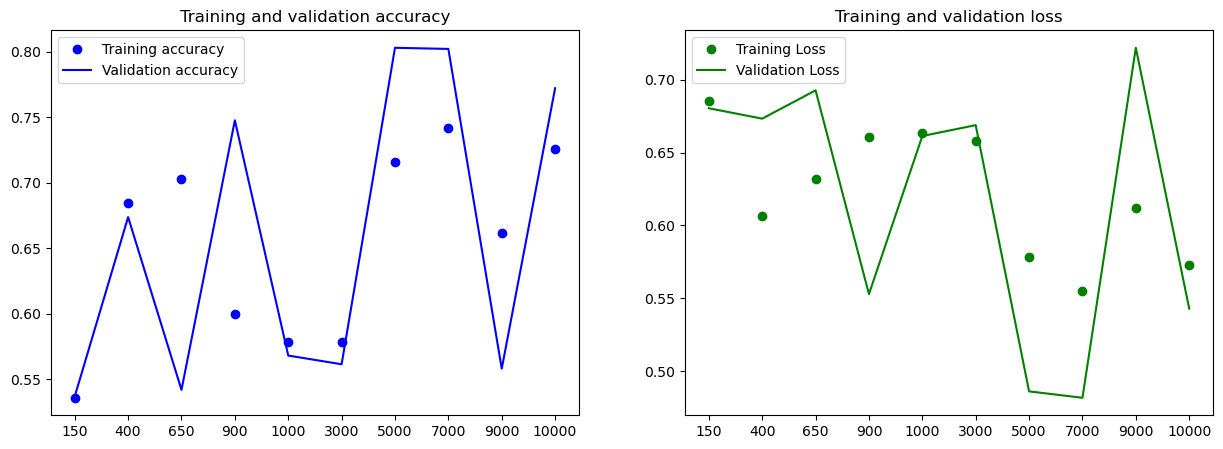

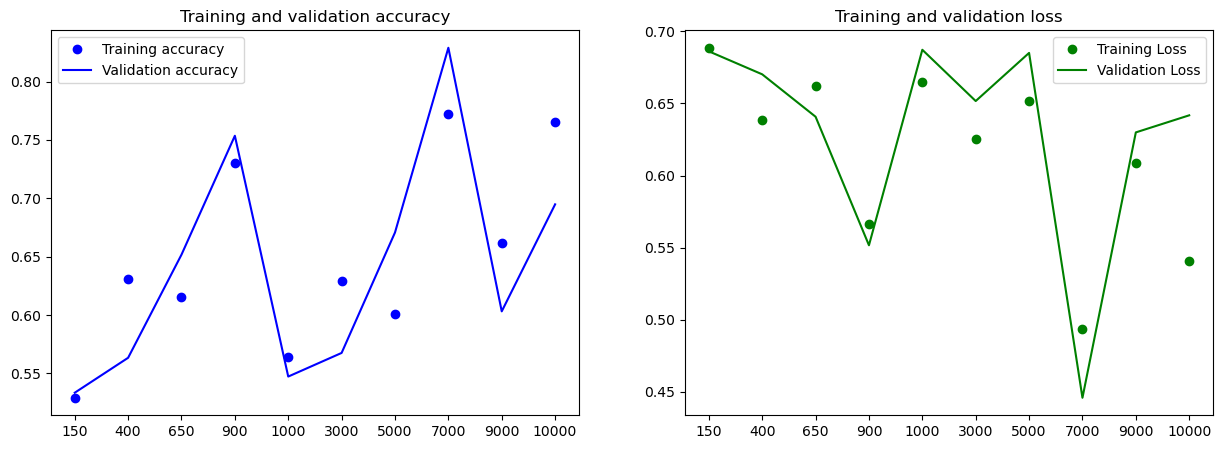

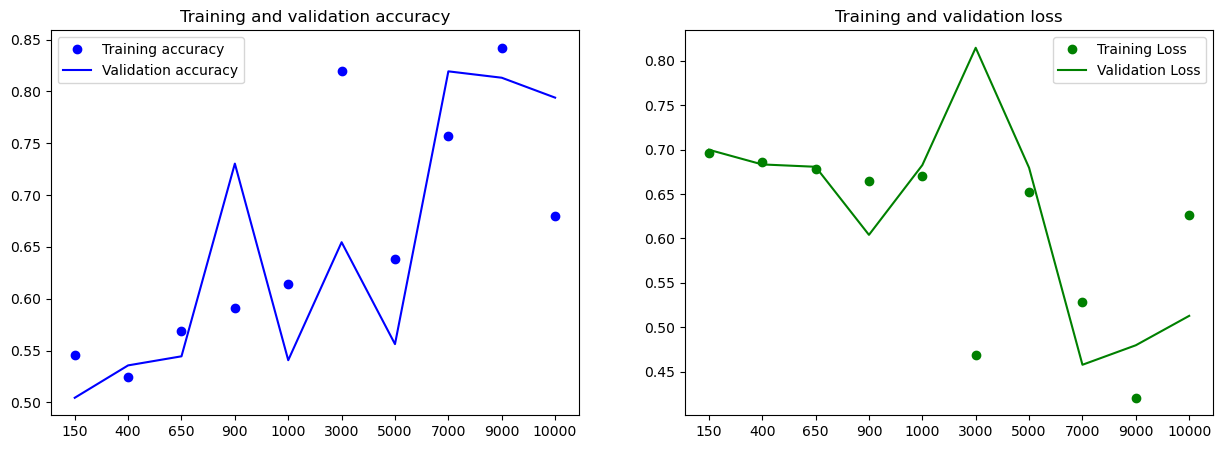

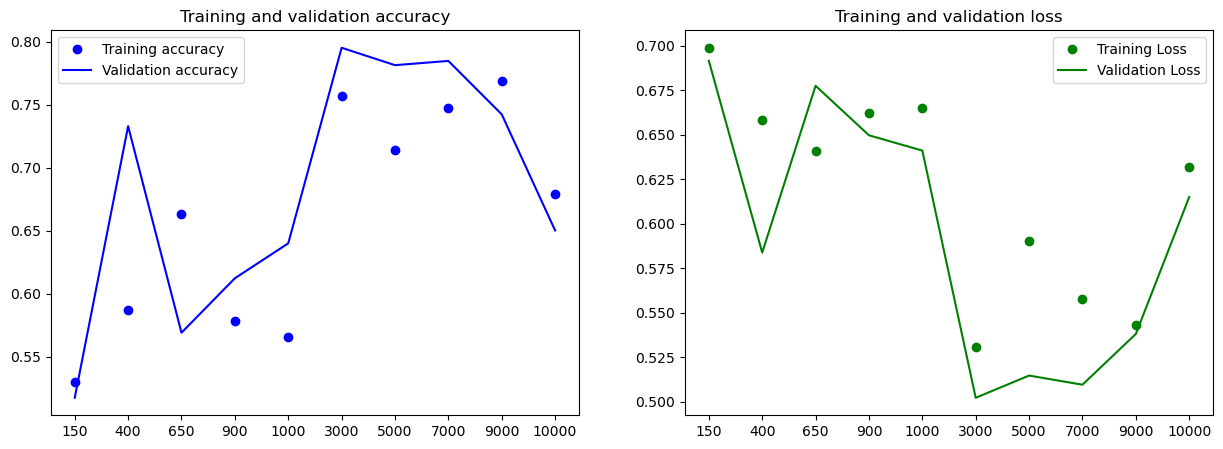

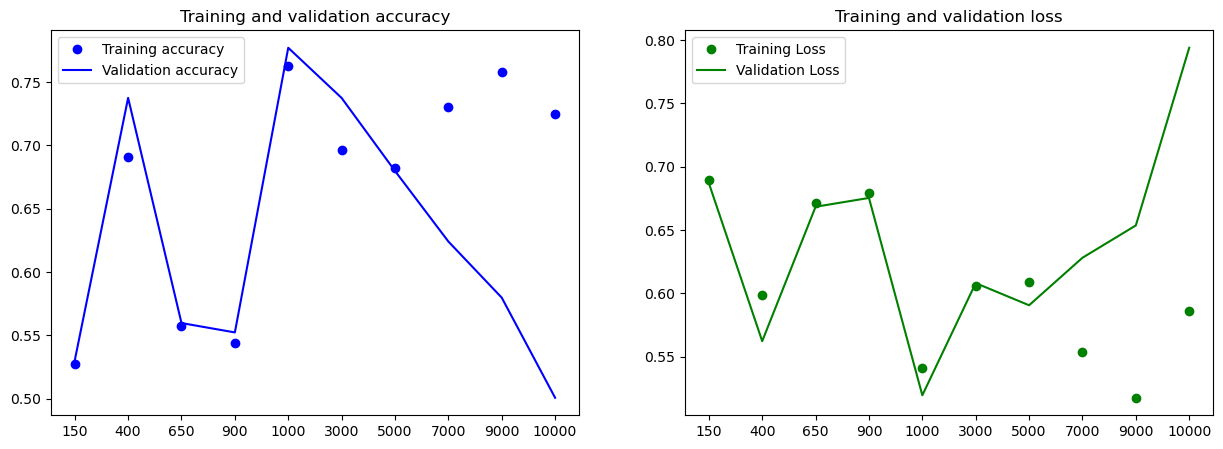

In [35]:
plotAccLossDiagram(batchV_models_score, batchV_models_history, vocab_size_range)

### Усредненное из 5

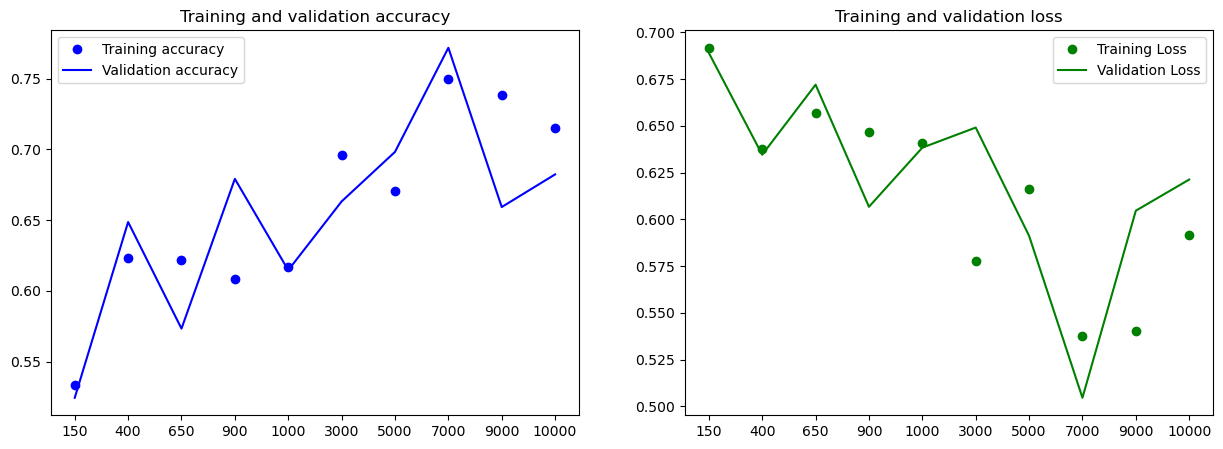

In [36]:
plotAccLossDiagramMean(batchV_models_score, batchV_models_history, vocab_size_range)

## Изменим длину отзыва

In [38]:
vocab_size = 7000
layer_neuron_count = 32

review_length_range = np.arange(100, 600, 75)

In [39]:
batchR_models_history = []
batchR_models_score = []

(X_train, y_train), (X_test, y_test) = loadDataIMDB(vocab_size)

for i in range(5):
    models_history = []
    models_score = []
    for review_length in review_length_range:
        X_train_normalized, X_test_normalized = normalizeDataSet(review_length, X_train, X_test)

        model = createModelLSTM(vocab_size, layer_neuron_count, review_length)
        h, s = processModel(model, X_train_normalized, y_train, X_test_normalized, y_test)
        models_history.append(h)
        models_score.append(s)
    
    batchR_models_history.append(models_history)
    batchR_models_score.append(models_score)
    print(f"==== {i} iter done")

782/782 [==============================] - 14s 18ms/step - loss: 0.6856 - accuracy: 0.5347
==== 0 iter done
782/782 [==============================] - 14s 18ms/step - loss: 0.6861 - accuracy: 0.5176
==== 1 iter done
782/782 [==============================] - 15s 19ms/step - loss: 0.6863 - accuracy: 0.5157
==== 2 iter done
782/782 [==============================] - 14s 18ms/step - loss: 0.6871 - accuracy: 0.5171
==== 3 iter done
782/782 [==============================] - 15s 19ms/step - loss: 0.6883 - accuracy: 0.5078
==== 4 iter done


### 5 прогонов дают разные результаты

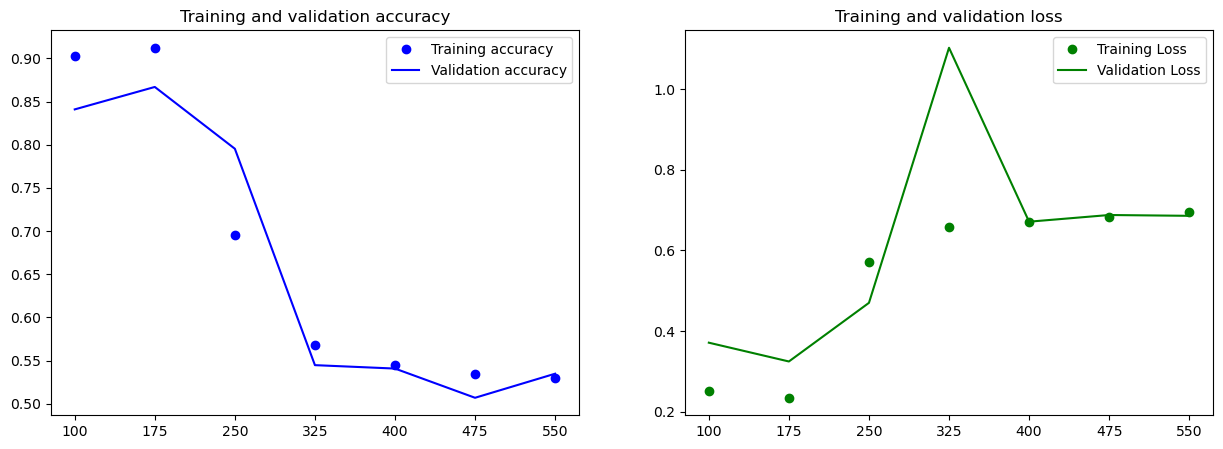

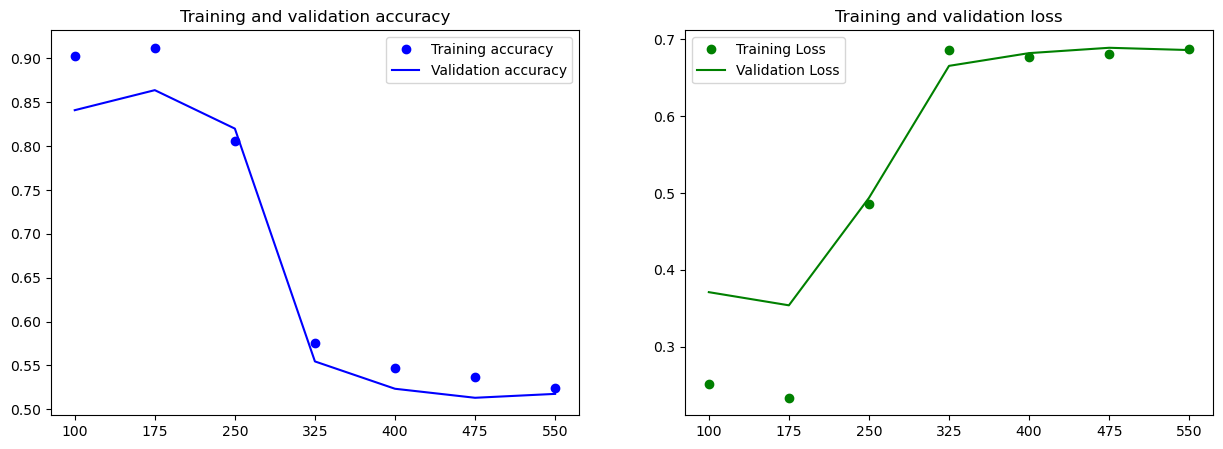

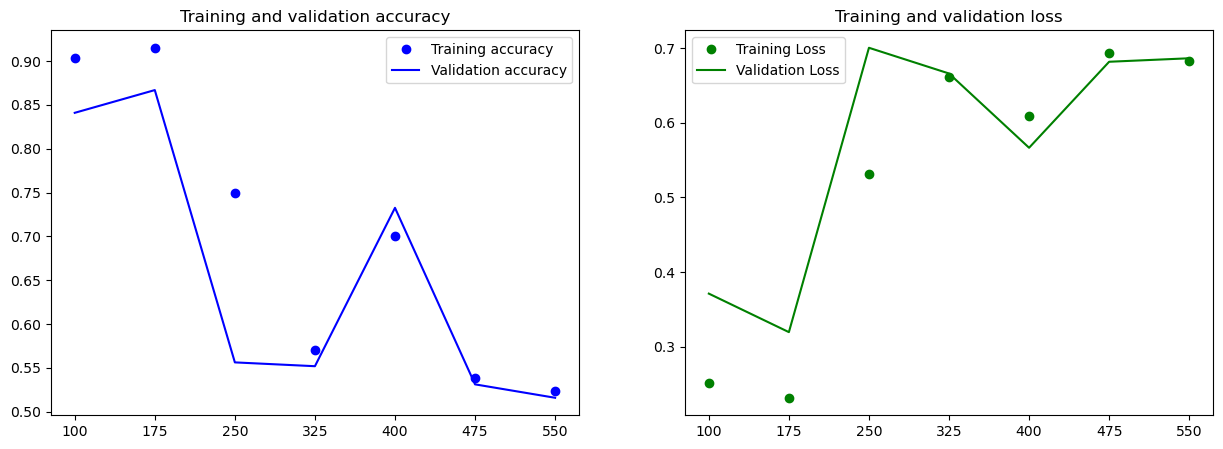

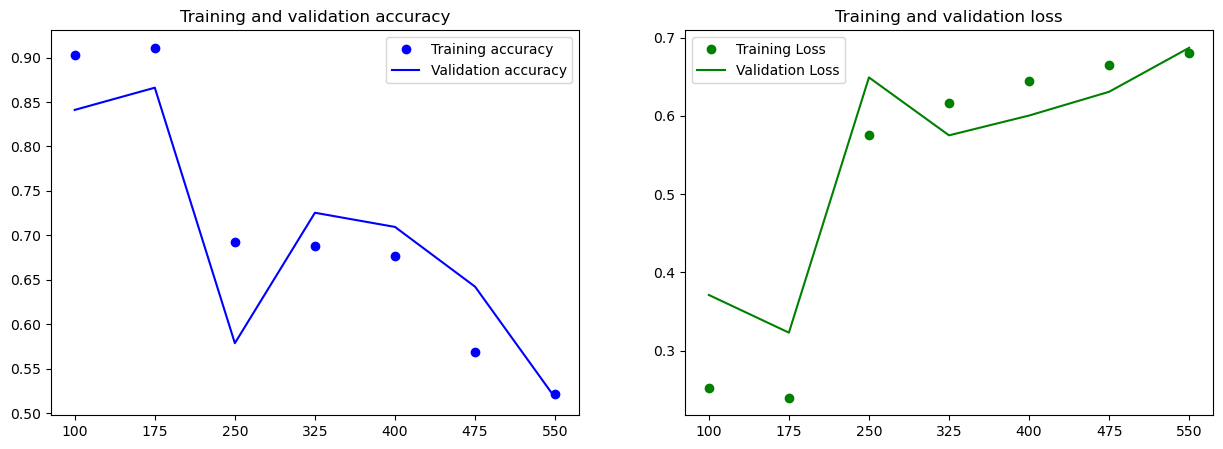

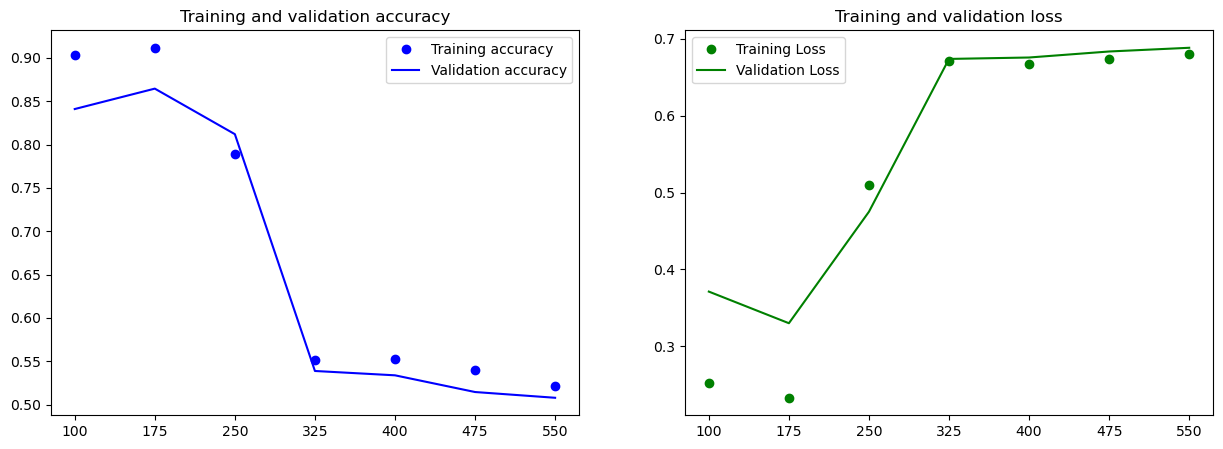

In [40]:
plotAccLossDiagram(batchR_models_score, batchR_models_history, review_length_range)

### Усредненное из 5

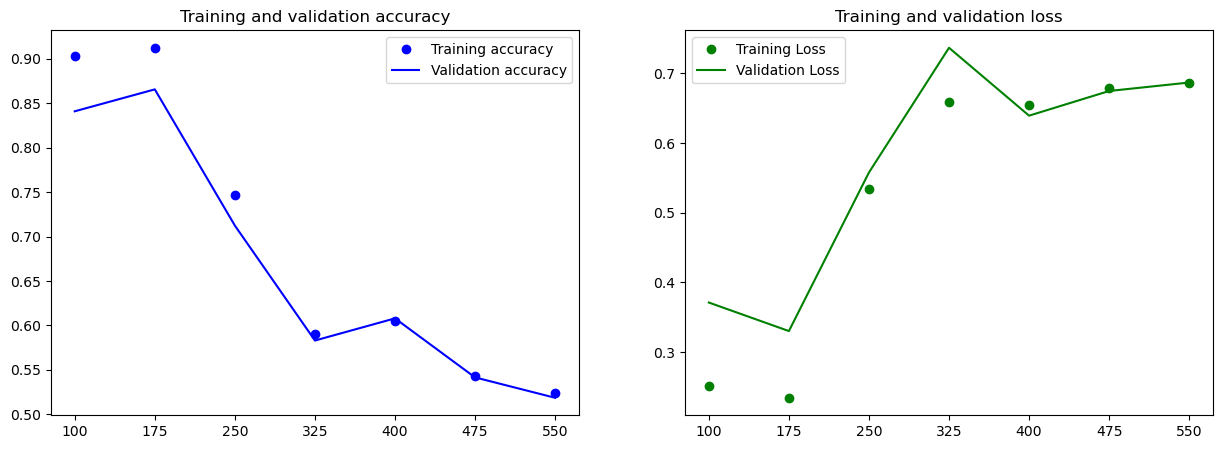

In [41]:
plotAccLossDiagramMean(batchR_models_score, batchR_models_history, review_length_range)

#### Попробуем подставить лучшее значение и перепрогнать изменение размера словаря 2 раза

In [45]:
review_length = 175 # оптимальное
layer_neuron_count = 32

vocab_size_range = np.arange(150, 1001, 250)
vocab_size_range = np.concatenate([vocab_size_range, np.arange(1000, 10001, 2000)])
vocab_size_range = np.concatenate([vocab_size_range, [10000, 15000, 20000]])

In [46]:
batchV2_models_history = []
batchV2_models_score = []

for i in range(2):
    models_history = []
    models_score = []
    for vocab_size in vocab_size_range:
        (X_train, y_train), (X_test, y_test) = loadDataIMDB(vocab_size)
        X_train_normalized, X_test_normalized = normalizeDataSet(review_length, X_train, X_test)

        model = createModelLSTM(vocab_size, layer_neuron_count, review_length)
        h, s = processModel(model, X_train_normalized, y_train, X_test_normalized, y_test)
        models_history.append(h)
        models_score.append(s)
    
    batchV2_models_history.append(models_history)
    batchV2_models_score.append(models_score)
    print(f"==== {i} iter done")

782/782 [==============================] - 7s 9ms/step - loss: 0.3304 - accuracy: 0.8665
==== 0 iter done
782/782 [==============================] - 9s 11ms/step - loss: 0.6642 - accuracy: 0.5832
==== 1 iter done


##### 2 похожих результата

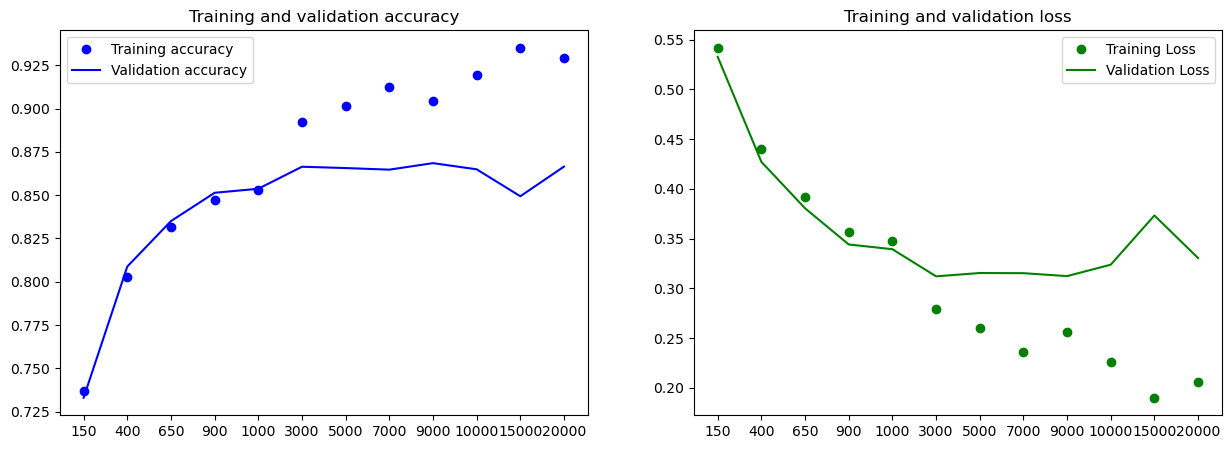

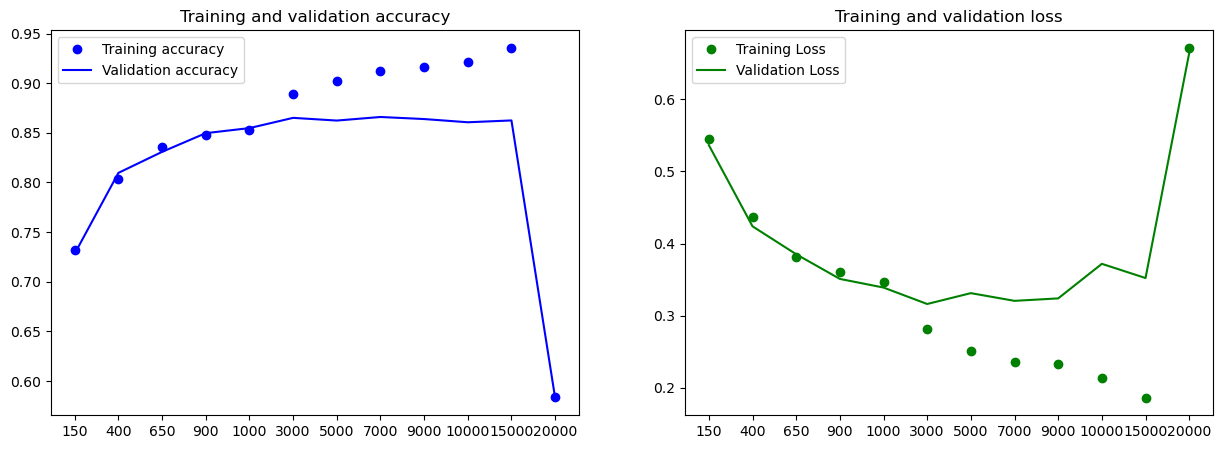

In [47]:
plotAccLossDiagram(batchV2_models_score, batchV2_models_history, vocab_size_range)

##### Усредненное

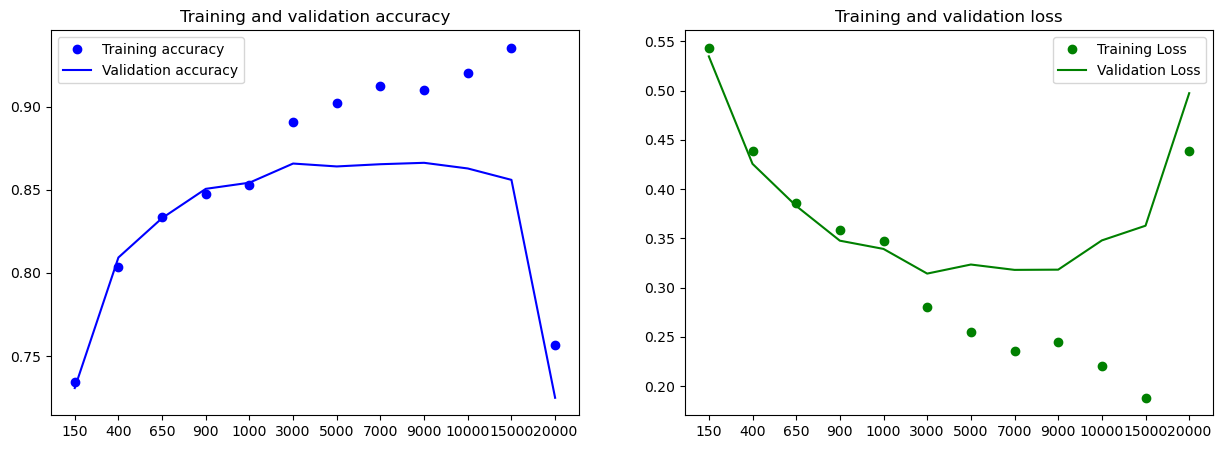

In [48]:
plotAccLossDiagramMean(batchV2_models_score, batchV2_models_history, vocab_size_range)

## Изменим размер слоя эмбеддинг

In [10]:
vocab_size = 3000
review_length = 175

layer_neuron_count_range = [2**x for x in range(3, 9)]

In [11]:
batchN_models_history = []
batchN_models_score = []

(X_train, y_train), (X_test, y_test) = loadDataIMDB(vocab_size)
X_train_normalized, X_test_normalized = normalizeDataSet(review_length, X_train, X_test)

for i in range(5):
    models_history = []
    models_score = []
    for layer_neuron_count in layer_neuron_count_range:
        model = createModelLSTM(vocab_size, layer_neuron_count, review_length)
        h, s = processModel(model, X_train_normalized, y_train, X_test_normalized, y_test)
        models_history.append(h)
        models_score.append(s)
    
    batchN_models_history.append(models_history)
    batchN_models_score.append(models_score)
    print(f"==== {i} iter done")

2022-10-20 10:46:11.250560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-20 10:46:11.291494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-20 10:46:11.291563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-20 10:46:11.292574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

782/782 [==============================] - 7s 9ms/step - loss: 0.6323 - accuracy: 0.6078
==== 0 iter done
782/782 [==============================] - 7s 9ms/step - loss: 0.6342 - accuracy: 0.6010
==== 1 iter done
782/782 [==============================] - 7s 9ms/step - loss: 0.6253 - accuracy: 0.6195
==== 2 iter done
782/782 [==============================] - 7s 9ms/step - loss: 0.6631 - accuracy: 0.5732
==== 3 iter done
782/782 [==============================] - 7s 9ms/step - loss: 0.7357 - accuracy: 0.5599
==== 4 iter done


### 5 прогонов дают разные результаты

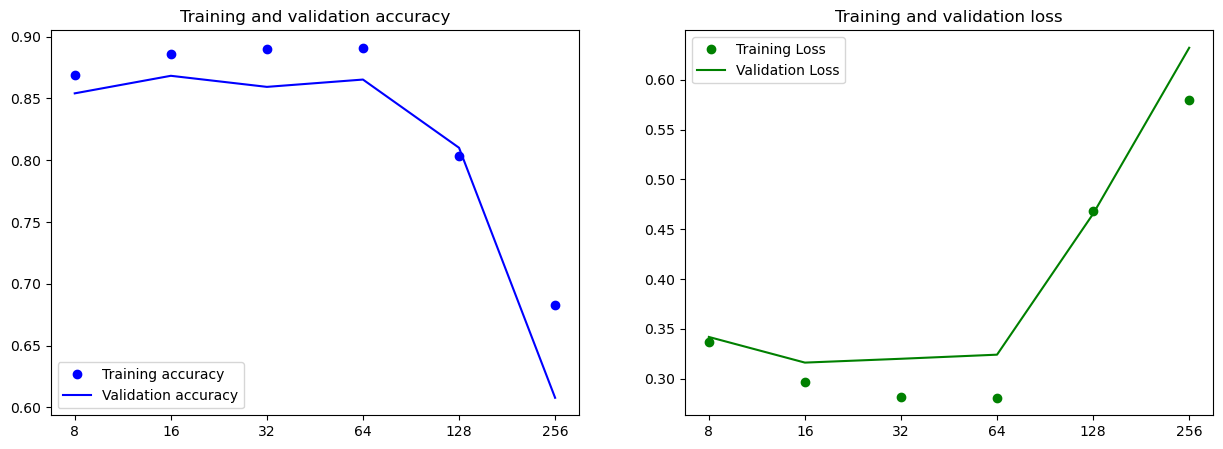

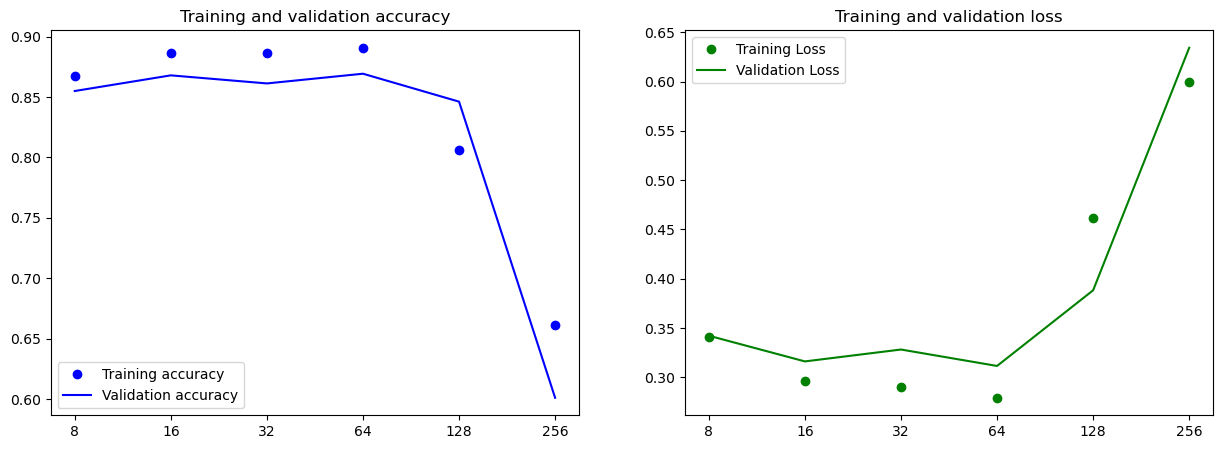

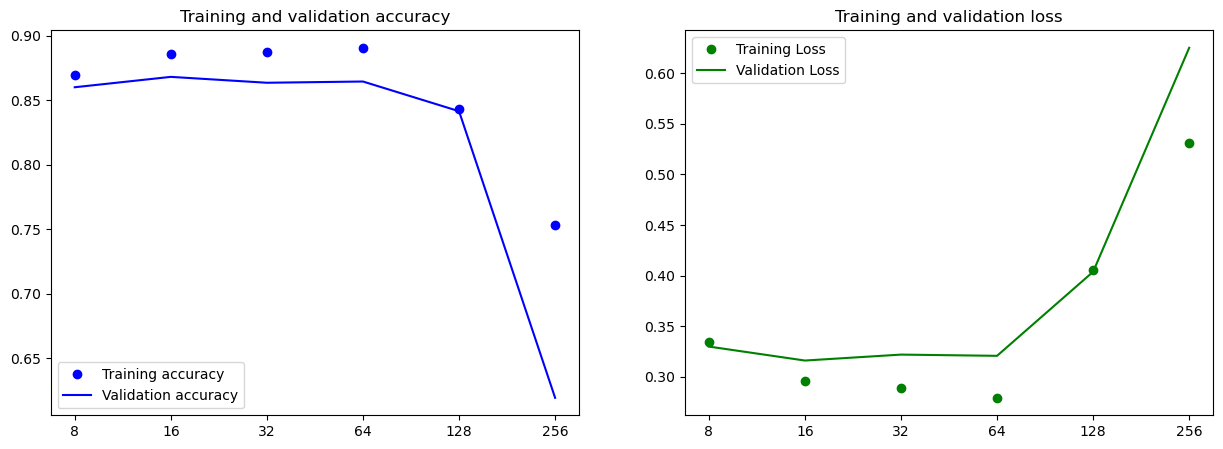

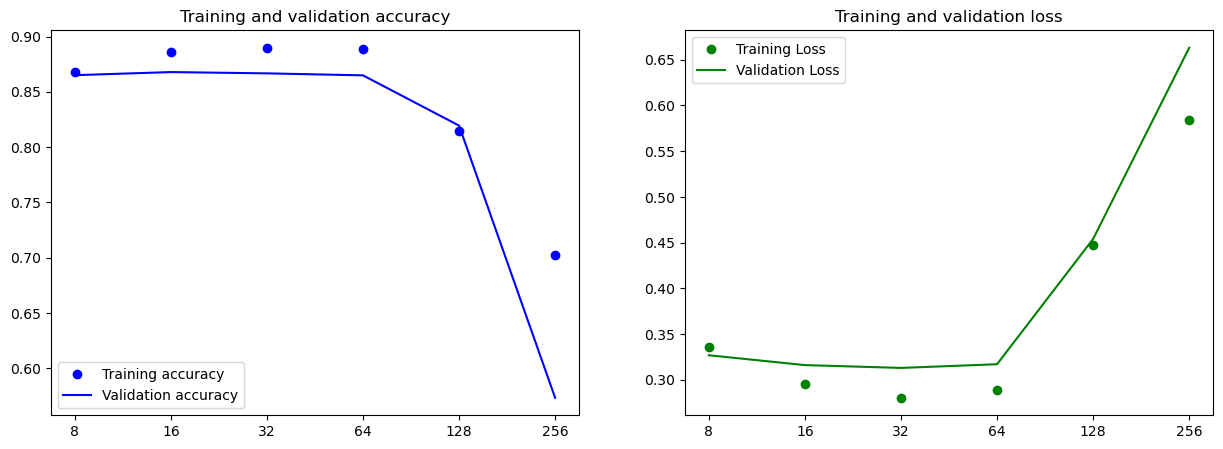

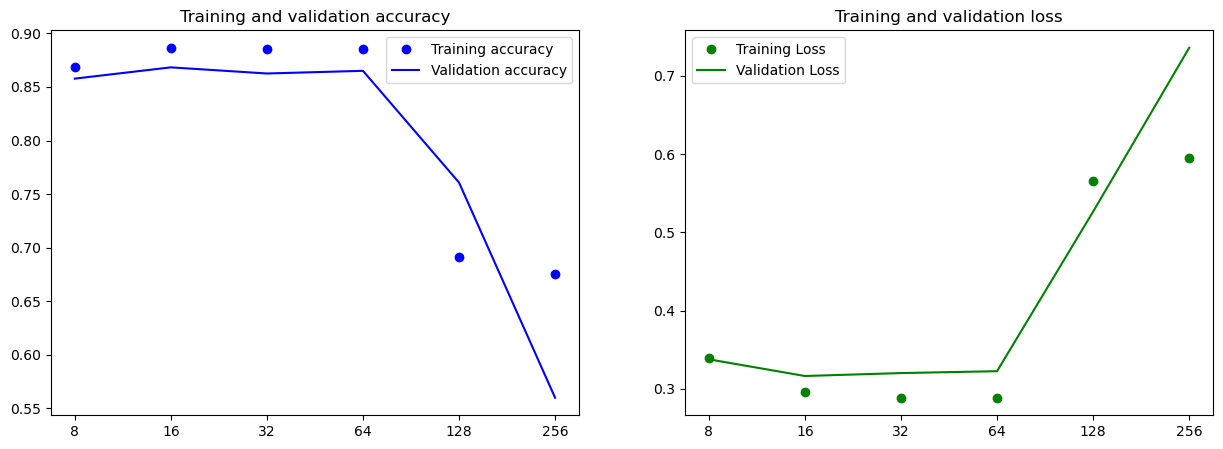

In [12]:
plotAccLossDiagram(batchN_models_score, batchN_models_history, layer_neuron_count_range)

### Усредненное из 5

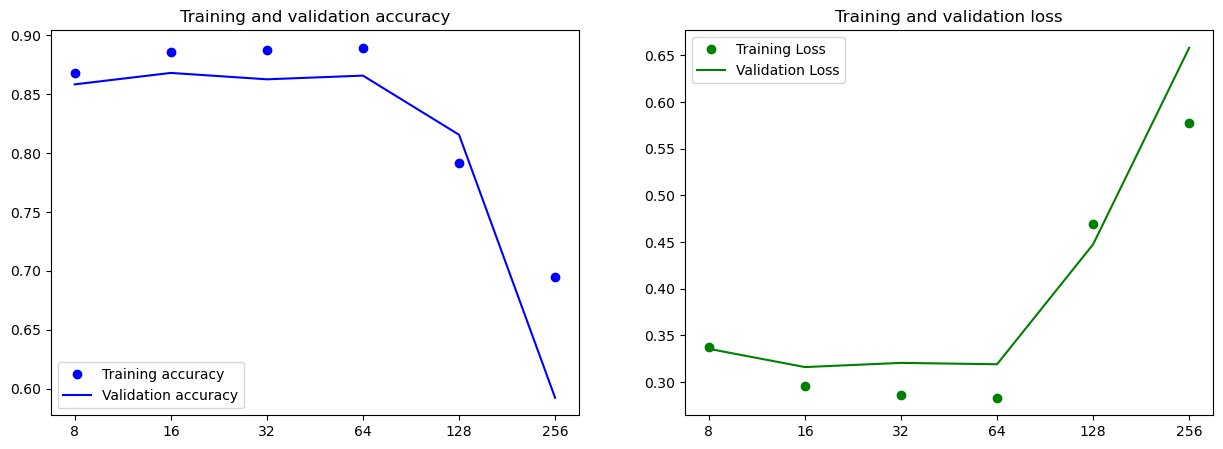

In [13]:
plotAccLossDiagramMean(batchN_models_score, batchN_models_history, layer_neuron_count_range)

## Итог подбора

In [32]:
vocab_size = 3000
review_length = 175
layer_neuron_count_range = 64

In [33]:
resetSeed()
(X_train, y_train), (X_test, y_test) = loadDataIMDB(vocab_size)
X_train_normalized, X_test_normalized = normalizeDataSet(review_length, X_train, X_test)

model = createModelLSTM(vocab_size, layer_neuron_count, review_length)
h, s = processModel(model, X_train_normalized, y_train, X_test_normalized, y_test)

# Get Model Predictions for test data
predicted_classes = predictModelLSTM(model, X_test_normalized)
print(classification_report(y_test, predicted_classes, target_names=class_names))

782/782 [==============================] - 5s 7ms/step
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67     12500
    Positive       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
h.history

{'loss': [0.6818172931671143, 0.5955777764320374, 0.4826561510562897],
 'accuracy': [0.5863500237464905, 0.6790000200271606, 0.7947999835014343],
 'val_loss': [0.6099290251731873, 0.552941083908081, 0.46378350257873535],
 'val_accuracy': [0.5971999764442444, 0.7771999835968018, 0.8080000281333923]}

In [35]:
s

[0.4592345356941223, 0.811519980430603]

Результат улучшался при массовых прогонах, но остался на прежнем уровне при единичном. Кроме магии рандома я не знаю как это объяснить

# Задание 2

Возьмите данные отзывов о фильмах сайта Кинопоиск ру из соревнования https://www.kaggle.com/mikhailklemin/kinopoisks-movies-reviews и попробуйте обучить рекурентную нейронную сеть, которая будет предсказывать sentiment по аналогии с практическим занятием по LSTM

## Import

In [4]:
from genericpath import exists
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.preprocessing import sequence

import numpy as np
from numpy import array
from numpy import iterable

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
import snowballstemmer
import logging
logging.getLogger('tensorflow').disabled = True

In [5]:
vocab_size = 3000
review_length = 175
layer_neuron_count = 64
trainToTestCoef = 0.4

In [6]:
class_names = ["Positive", "Neutral", "Negative"]
class_names_converter = {
    'neg': 'Negative',
    'pos': 'Positive',
    'neu': 'Neutral',
}

## Data Load

In [7]:
bDataNormalized = False
if not exists("dataset.json"):
    import glob
    rev_files = glob.glob("dataset/neg/*.txt")
    rev_files.extend(glob.glob("dataset/neu/*.txt"))
    rev_files.extend(glob.glob("dataset/pos/*.txt"))
    print(imgs_count := len(rev_files))

    df = pd.DataFrame(columns=['ID_FILM', 'ID_REV', 'Review', 'Sentiment'])
    for i, f in enumerate(rev_files):
        _, sent, fname = f.removesuffix(".txt").split('/')
        film_id, rev_id = fname.split('-')
        with open(f) as file:
            rev = file.read()
            current_df = pd.DataFrame({ 'ID_FILM':film_id,
                                        'ID_REV':rev_id, 
                                        'Review': [rev], 
                                        'Sentiment': class_names_converter[sent]})
            df = pd.concat([df, current_df], ignore_index=True)
    df.to_json("dataset.json")
elif exists("dataset_norm.json"):
    bDataNormalized = True
    df = pd.read_json("dataset_norm.json")
else:
    df = pd.read_json("dataset.json")

In [8]:
df.head()

,ID_FILM,ID_REV,Review,Sentiment
0,977288,21,труп ожив земл разрыв всюд выполз дик бушев гл...,Positive
1,77413,22,я не зна что дел возможн сто беж от эт мир пос...,Positive
2,307012,45,прочит куч реценз к эт фильм и скаж что скольк...,Positive
3,402641,1,соврем испанск преимуществ каталанск триллер б...,Neutral
4,919515,23,коротк метр иногд стан путевк в больш кин как ...,Positive


### Normalization

#### Чистка данных

In [6]:
if not bDataNormalized:
    df = df.sample(frac=1).reset_index(drop=True)
    content_field = "Review"
    df[content_field] = df[content_field].str.lower()                                           # переводим всё в нижний геристр
    df[content_field] = df[content_field].str.replace(r"http\S+", "", regex=True)               # удаляем ссылки
    df[content_field] = df[content_field].str.replace(r"@\S+", "", regex=True)                  # удаляем обращения
    df[content_field] = df[content_field].str.replace(r"[ё]", "е", regex=True)
    df[content_field] = df[content_field].str.replace(r"[\t\n]", " ", regex=True)
    df[content_field] = df[content_field].str.replace(r"[^а-яa-z]", " ", regex=True)

#### Stemmer

In [73]:
stemmer = snowballstemmer.stemmer('russian')

In [74]:
def stummText(text):
    return ' '.join(stemmer.stemWords(text.split()) )

In [10]:
if not bDataNormalized:
    corpus = []

    for i in range(len(df['Sentiment'])):
        df['Review'][i] = stummText(df['Review'][i])
        print(i) # progress checker
    df.to_json("dataset_norm.json")

### Разделение на тестовые и тренировочные

In [11]:
data_train, data_test = train_test_split(df, test_size=trainToTestCoef)

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,)
tokenizer.fit_on_texts(df['Review'])

In [13]:
def prep_text(texts, tokenizer, max_sequence_length):
    text_sequences = tokenizer.texts_to_sequences(texts)
    return tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_sequence_length)

def prep_output(output):
    return class_names.index(output)

In [50]:
X_train = prep_text(data_train['Review'], tokenizer, review_length)
X_test = prep_text(data_test['Review'], tokenizer, review_length)

y_train = np.stack(data_train['Sentiment'].map(prep_output))
y_test = np.stack(data_test['Sentiment'].map(prep_output))

In [51]:
y_train = np.array([[1, 0 ,0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1]) for x in y_train])
y_test = np.array([[1, 0 ,0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1]) for x in y_test])

In [52]:
print(f"Shape Training Review Data: {X_test.shape}")
print(f"Shape Training Class Data: {y_train.shape}")
print(f"Shape Test Review Data: {X_test.shape}")
print(f"Shape Test Class Data: {y_test.shape}")

Shape Training Review Data: (52668, 175)
Shape Training Class Data: (79001, 3)
Shape Test Review Data: (52668, 175)
Shape Test Class Data: (52668, 3)


## Обучение

In [53]:
model = createModelLSTM(target_vocab_size = vocab_size, 
                        target_layer_neuron_count = layer_neuron_count, 
                        target_review_length = review_length,
                        dropout_rate = 0.20, 
                        out_units = 3)

2022-10-21 19:06:26.075913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-21 19:06:26.115702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-21 19:06:26.115793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-21 19:06:26.117224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [54]:
best_loss = 10000
patience = 1
patience_count = patience
for i in range(20):
    print(f"=== On epoch {i+1}/20: ===")
    print('Training:')
    history = model.fit(
        X_train, y_train,                   
        batch_size=256, 
        epochs=1, 
        verbose=1,
    ) 
    print('Evaluating:')
    loss, _ = model.evaluate(X_test, y_test)

    if loss > best_loss:
        best_loss *= 1.03
        patience_count -= 1
    else:
        best_loss = loss
        patience_count = patience
    
    if loss < 0.4:
        print('Goal reached, stopping now')
        break
    if patience_count <= 0:
        print('It only getting worse, stopping now')
        break

=== On epoch 1/20: ===
Training:


2022-10-21 19:06:49.440594: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-21 19:06:51.242398: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


309/309 [==============================] - 11s 20ms/step - loss: 0.4541 - accuracy: 0.6888
Evaluating:
1646/1646 [==============================] - 15s 9ms/step - loss: 0.3858 - accuracy: 0.7350
Goal reached, stopping now


In [80]:
review1 = 'Фильм Очень плохое кино оказался хорошим'
review2 = 'Зря потраченное время'
review3 = 'Ужасный фильм, зря потраченное время'
review4 = 'Фильм под названием фильм является настолько плохим что плохо ужасно'
aReview = [review1, review2, review3, review4]

for review in aReview:
    tmp_padded = prep_text([stummText(review)], tokenizer, review_length)
    rawprediction = np.argmax(model.predict(tmp_padded))

    print(f"Review: {review}")
    print(f"Raw Prediction: {rawprediction}")
    print(f"Predicted Class: {class_names[int(np.round(rawprediction))]}")
    print("")

1/1 [==============================] - 0s 33ms/step
Review: Фильм Очень плохое кино оказался хорошим
Raw Prediction: 0
Predicted Class: Positive

1/1 [==============================] - 0s 20ms/step
Review: Зря потраченное время
Raw Prediction: 2
Predicted Class: Negative

1/1 [==============================] - 0s 19ms/step
Review: Ужасный фильм, зря потраченное время
Raw Prediction: 2
Predicted Class: Negative

1/1 [==============================] - 0s 21ms/step
Review: Фильм под названием фильм является настолько плохим что плохо ужасно
Raw Prediction: 2
Predicted Class: Negative

